<a href="https://colab.research.google.com/github/TrevorIkky/Informer/blob/main/Informer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf

tf.config.run_functions_eagerly(True)

# **Masks**
Apply padding mask to values in encoder
Apply combined mask (lookahead, padding) and padding mask to decoder. The combined mask applied to the first MHA, the padding mask applied to the second MHA in the decoder.

In [ ]:
def padding_mask(sequence):
  mask = tf.cast(tf.equal(sequence, 0), dtype=tf.float32)
  return mask[:, tf.newaxis, tf.newaxis, :]

def look_ahead_mask(seq_len):
  mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  return mask


def prob_lookahead_mask(B, H, L_Q, I, S):
  mask = tf.ones([L_Q, S.shape[-1]], tf.float32)

  mask = 1 - tf.linalg.band_part(mask, -1, 0)
  mask_expanded = tf.broadcast_to(mask, [B, H, L_Q, S.shape[-1]])
  #mask specific q based on reduced Q
  mask_Q = tf.gather_nd(mask_expanded, I)
  mask_Q = tf.cast(tf.reshape(mask_Q, S.shape), tf.bool)
  return mask_Q

def combined_mask(padding_mask, look_ahead_mask):
  return tf.maximum(padding_mask, look_ahead_mask) 

# #Padding mask
# S = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
# X = padding_mask(S)
# Y = look_ahead_mask(S.shape[-1])
# M = tf.maximum(X, Y)
# print(f'Padding mask: {X}\n\nLook ahead mask {Y}\n\ntf.max: {M}')

# **Embedding Layers**

In [ ]:
from tensorflow.keras.initializers import HeNormal, Constant
from tensorflow.keras.layers import Add, Conv1D, LeakyReLU, Embedding, Dropout, Layer

In [ ]:
"""
PositionalEncoding:
Args:

Notes:
gY = 256, 50, gX = 256, 50
np.sin.shape=(50,256) , np.cos.shape = (50,256)
We are selecting every 2 pos. Therefore the total number of pos
is 256 where at each pos we put the 50.
"""

class PositionalEmbedding(Layer):
  def __init__(self, embedding_dim, max_seq_len=5000, **kwargs):
    super(PositionalEmbedding, self).__init__()
    self.max_seq_len = max_seq_len
    self.embedding_dim = embedding_dim

    if self.embedding_dim % 2 == 1 : self.embedding_dim += 1
    gX, gY = np.meshgrid(np.arange(self.max_seq_len), np.arange(self.embedding_dim // 2)) #50, 256
    pE = np.empty((1, self.max_seq_len, self.embedding_dim)) # 50, 512
    print(pE[0, :, ::2].shape)
    print(np.sin(gX / 10000**(2 * gY / self.embedding_dim)).shape)
    pE[0, :, ::2] = np.sin(gX / 10000**(2 * gY / self.embedding_dim)).T
    pE[0, :, 1::2] = np.cos(gX / 10000**(2 * gY / self.embedding_dim)).T
    self.pE = tf.constant(pE, dtype=tf.float32)

  def call(self, x):
    x_shape = tf.shape(x)
    return tf.tile(self.pE[:, :x_shape[-2], :], [x_shape[0], 1, 1])

  def get_config(self):
    config = super(PositionalEmbedding, self).get_config()
    config.update({ "max_seq_len": self.max_seq_len, "embedding_dim": self.embedding_dim })
    return config

In [ ]:
pos_x = tf.random.uniform((32, 96, 7), minval=0, maxval=1)
pos_emb = PositionalEmbedding(512)(pos_x)
pos_emb.shape

(5000, 256)
(256, 5000)


TensorShape([32, 96, 512])

In [ ]:
"""
Args:
tX = input
dim_model = model dimension 

Notes:
LeakyRelU = alpha * x if x < 0 else x if x > 0
"""
class TokenEmbedding(Layer):
  def __init__(self, dim_model, **kwargs):
    super(TokenEmbedding, self).__init__()
    self.dim_model = dim_model
    self.token_conv = Conv1D(dim_model, 3, padding='causal', activation= LeakyReLU(), kernel_initializer=HeNormal())
  
  def call(self, x):
    x = self.token_conv(x)
    return x
  
  def get_config(self):
    config = super(TokenEmbedding, self).get_config()
    config.update({ "dim_model": self.dim_model })
    return config


In [ ]:
"""
Args:
fX = input
eI = encoder input = 7
dim_model = model dimension = 512
"""
class FixedEmbedding(Layer):
  def __init__(self, input_size, dim_model, **kwargs):
    super(FixedEmbedding, self).__init__()
    self.input_size = input_size
    self.dim_model = dim_model

    if self.dim_model % 2 == 1 : self.dim_model += 1
    gX, gY = np.meshgrid(np.arange(self.input_size), np.arange(self.dim_model // 2)) #50, 256
    W = np.empty((1, self.input_size, self.dim_model)) # 50, 512
    W[0, :, ::2] = np.sin(gX / 10000**(2 * gY / self.dim_model)).T
    W[0, :, 1::2] = np.cos(gX / 10000**(2 * gY / self.dim_model)).T
    W = tf.constant(W, dtype=tf.float32)
    tf.stop_gradient(W)
    W = Constant(W)

    self.E = Embedding(self.input_size, self.dim_model, embeddings_initializer=W, trainable=False)

  def call(self, x):
    return self.E(x)

  def get_config(self):
    config = super(FixedEmbedding, self).get_config()
    config.update({ "input_size": self.input_size, "dim_model": self.dim_model })
    return config

In [ ]:
"""
Args:
pX = input
dim_model = model_dimension = 512
"""

class TemporalEmbedding(Layer):
  def __init__(self, dim_model=512, embed_type="fixed", frequency="h", **kwargs):
    super(TemporalEmbedding, self).__init__()

    self.embed_type = embed_type
    self.frequency = frequency
    
    min = 4
    hr = 24
    wk = 7
    dy = 32
    mon = 13

    Embed = FixedEmbedding if self.embed_type == 'fixed' else Embedding
    
    if self.frequency == "m":
      self.minute_embed = Embed(min, dim_model)
    self.hour_embed = Embed(hr, dim_model)
    self.weekday_embed = Embed(wk, dim_model)
    self.day_embed = Embed(dy, dim_model)
    self.month_embed = Embed(mon, dim_model)

  def call(self, x):
    min_x = self.minute_embed(x[:, :, 4]) if hasattr(self, 'minute_embed') else 0.
    hour_x = self.hour_embed(x[:, :, 3])
    weekday_x = self.weekday_embed(x[:, :, 2])
    day_x = self.day_embed(x[:, :, 1])
    month_x = self.month_embed(x[:, :, 0])

    return hour_x + weekday_x + day_x + month_x + min_x

  def get_config(self):
    config = super(TemporalEmbedding, self).get_config()
    config.update({ "embed_type": self.embed_type, "frequency": self.frequency })
    return config



In [ ]:
class TimeFeatureEmbedding(Layer):
  def __init__(self, dim_model):
    super(TimeFeatureEmbedding, self).__init__()
    self.embedding = Dense(dim_model)
  def call(self, x):
    return self.embedding(x)

In [ ]:
class DataEmbedding(Layer):
  def __init__(self, dim_model=512, embed_type="time_features", freq="h", dropout_rate=0.1, training=False, **kwargs):
    super(DataEmbedding, self).__init__()

    self.dim_model = dim_model
    self.embed_type = embed_type
    self.freq = freq
    self.dropout_rate = dropout_rate

    self.training = training

    self.val_embedding = TokenEmbedding(self.dim_model)
    
    if embed_type != "time_features":
      self.temp_embedding = TemporalEmbedding(self.dim_model, self.embed_type, self.freq)
    else:
      self.temp_embedding = TimeFeatureEmbedding(self.dim_model)
    
    self.pos_embedding = PositionalEmbedding(self.dim_model)

    self.add = Add()
    self.dropout = Dropout(self.dropout_rate)
    
  def call(self, x, x_mark):
    embedding = self.add([self.val_embedding(x), self.temp_embedding(x_mark), self.pos_embedding(x)])
    embedding = self.dropout(embedding, training=self.training)
    return embedding

  def get_config(self):
    config = super(DataEmbedding, self).get_config()
    config.update({ "training": self.training, "dim_model": self.dim_model, "freq": self.freq, "dropout_rate": self.dropout_rate })
    return config


In [ ]:
# data_embedding_x = tf.random.uniform((32, 96, 7), minval=0, maxval=1)
# mark_embedding_x = tf.random.uniform((32, 96, 4), minval=0, maxval=7)
# data_embedding_x = DataEmbedding(512, training=True)(data_embedding_x, mark_embedding_x)
# data_embedding_x.shape

# **Multi-Head Attention**

In [ ]:
from math import sqrt
from typing import Tuple, List
from tensorflow.keras.layers import Dense, Lambda

In [ ]:
# Q = tf.random.uniform((4, 2, 2, 3), minval=0, maxval=1, dtype=tf.int32)
# batch_indexes = tf.tile(tf.range(Q.shape[0])[:, tf.newaxis, tf.newaxis], (1, Q.shape[1], 2))
# head_indexes = tf.tile(tf.range(Q.shape[1])[tf.newaxis, :, tf.newaxis], (Q.shape[0], 1, 2))
# pre = tf.constant([[1, 1], [0, 1]])
# pre = tf.tile(pre[tf.newaxis, : ], [Q.shape[0], 1, 1]) #2 = Batch size.
# idx = tf.stack(values=[batch_indexes, head_indexes, pre], axis=-1)
# # idx, batch_indexes, head_indexes
# pre, idx

**Vanilla Attention**<br>
Args: K, V, Q, h, mask<br>
K = Keys, V = values, Q = queries, mask=combined, lookahead, padding mask, none

Output: Tuple(Tensor, Tensor)<br>
Tensor1 = attention weights * values, shape = (B, L, D)<br>
Tensor2 = attention weights, shape = (B, H, L_Q, L, V)

In [ ]:
@tf.function
def VanillaAttention(K, V, Q, h, dropout_rate=0.1, mask_flag=True, mask=None, training=True) -> Tuple[tf.Tensor, tf.Tensor]:
  sQ = tf.shape(Q)
  # vB, vL_Q, vH, vE = Q.shape
  B = sQ[0]
  L_Q = sQ[1]
  H = sQ[2]
  E = tf.cast(sQ[-1], tf.float32)
  
  a = tf.einsum('nqhd, nkhd -> nhqk', Q, K)

  if mask_flag:
    if mask is not None:
      a += (mask * -1e9)

  x = a / tf.math.sqrt(E)
  x = tf.nn.softmax(x, axis=-1)
  x = Dropout(dropout_rate)(x, training=True)
  x = tf.einsum('nhqk, nkhd -> nqhd', a, V)
 
  x = tf.reshape(x, [B, L_Q, -1])
  
  return x , a    

**Prob Attention**

In [ ]:
@tf.function
def ProbAttention(K, V, Q, c=5, mask_flag=True, output_attn=True) -> Tuple[tf.Tensor, tf.Tensor]:

  B, L_K, H, E = K.shape
  _, L_Q, _, _ = Q.shape
  
  p = [0, 2, 1, 3]

  K = tf.transpose(K, perm=p)
  Q = tf.transpose(Q, perm=p)
  V = tf.transpose(V, perm=p)

  #Sample keys to calculate query sparsity measurement on
  #c = factor
  U = c * np.ceil(np.log(L_K)).astype('int').item()
  u = c * np.ceil(np.log(L_Q)).astype('int').item()

  U = U if U < L_K else L_K
  u = u if u < L_Q else L_Q

  #Top scores, Query Indices
  S, Q_I = prob_QK(K, Q, U, u)
  S = S * 1./sqrt(E)
 
  context = get_initial_context(mask_flag, V, L_Q)

  context, A = update_context(context, S, V, Q_I, L_Q, mask_flag, output_attn)

  return context, A

def prob_QK(K, Q, sample_k, u) -> Tuple[tf.Tensor, tf.Tensor]:
  B, H, L_K, E = K.shape
  _, _, L_Q, _ = Q.shape

  K_E = tf.broadcast_to(tf.expand_dims(K, axis=-3), [B, H, L_K, L_Q, E])
  #sample_k = c * ln(L_K)
  K_rand_idx = tf.random.uniform((L_Q, sample_k), maxval=L_K, dtype=tf.int32)

  K_rand_idx = tf.tile(K_rand_idx[tf.newaxis, tf.newaxis, : ], [B, H, 1, 1]) #2 = Batch size.

  batch_indexes = tf.tile(tf.range(B)[:, tf.newaxis, tf.newaxis, tf.newaxis], (1, H, L_K, K_rand_idx.shape[-1]))
  head_indexes = tf.tile(tf.range(H)[tf.newaxis, :, tf.newaxis, tf.newaxis], (B, 1, L_K, K_rand_idx.shape[-1]))
  k_indexes = tf.tile(tf.range(L_K)[tf.newaxis, tf.newaxis, :, tf.newaxis ], (B, H, 1, K_rand_idx.shape[-1]))
 
  
  K_rand_idx = tf.stack(values=[batch_indexes, head_indexes, k_indexes, K_rand_idx], axis=-1)
  
  K_sample = tf.gather_nd(K_E, K_rand_idx)
 
  Q_K_sample = tf.squeeze(tf.matmul(tf.expand_dims(Q, axis=-2), tf.transpose(K_sample, [0, 1, 2, 4, 3])))

  #u = c * ln(L_Q)
  M = tf.reduce_max(Q_K_sample, axis=-1) - tf.divide(tf.reduce_sum(Q_K_sample, axis=-1), L_K)
  
  M_top = tf.math.top_k(M, u, sorted=False)[1]

  M_top = M_top[tf.newaxis] if B == 1 else M_top

  M_top = tf.tile(M_top, (1, 1, 1)) 
  
  batch_indexes = tf.tile(tf.range(B)[:, tf.newaxis, tf.newaxis], (1, H, u))
  head_indexes = tf.tile(tf.range(H)[tf.newaxis, :, tf.newaxis], (B, 1, u))
  
  rQ_idx = tf.stack(values=[batch_indexes, head_indexes, M_top], axis=-1)

  #Q_K interactions = L_K * ln (L_Q) * c (drop the constant)
  #                 = L_K * ln (L_Q)

  R_Q = tf.gather_nd(Q, rQ_idx)
  Q_K = tf.matmul(R_Q, tf.transpose(K, perm=[0, 1, 3, 2]))

  return Q_K, M_top


def get_initial_context(mask_flag, V, L_Q) -> tf.Tensor:
  B, H, L_V, E = V.shape 

  if not mask_flag: #context returned is same shape as Q
    m = tf.math.reduce_mean(V, axis=-2)
    context = tf.identity(tf.broadcast_to(tf.expand_dims(m, axis=-2), [B, H, L_Q, m.shape[-1]]))
  else: #Context returned is same shape as V
    assert L_Q == L_V, "Initial context: L_Q != L_V"
    context = tf.math.cumsum(V, axis=-2)
  
  return context

def update_context(context_in, scores, V, Q_I, L_Q, mask_flag=True, output_attn=True) -> Tuple[tf.Tensor, tf.Tensor]:
  B, H, L_V, E = V.shape

  batch_indexes = tf.tile(tf.range(B)[:, tf.newaxis, tf.newaxis], (1, H, Q_I.shape[-1]))
  head_indexes = tf.tile(tf.range(H)[tf.newaxis, :, tf.newaxis], (B, 1, Q_I.shape[-1]))

  ctx_I = tf.stack(values=[batch_indexes, head_indexes, Q_I], axis=-1)

  if mask_flag:
    mask = prob_lookahead_mask(B, H, L_Q, ctx_I, scores)
    scores = tf.where(mask, -np.inf, scores)

  a = tf.nn.softmax(scores, axis=-1)
  x = tf.matmul(a, V) #shape: B, H, Q, D
 
  context_in = tf.tensor_scatter_nd_update(context_in, ctx_I, x)

  context_in = tf.transpose(context_in, [0, 2, 1, 3])

  context_in = tf.reshape(context_in, [B, L_Q, -1])
 
  if output_attn:
    attns = (tf.ones((B, H, L_V, L_V)) / L_V)
    attns = tf.tensor_scatter_nd_update(attns, ctx_I, a)
    return context_in, attns
  else:
    return context_in, None

In [ ]:
# pX = tf.constant([[[[-0.5034, -1.1429,  0.4153],
#           [ 0.3051,  0.1895, -2.0370]],

#          [[-0.2590, -0.6820, -0.2117],
#           [-0.8491, -1.2988, -0.3452]]]])
# pX = ProbAttention(pX, pX, pX, mask_flag=True)[0]
# pX.numpy()

In [ ]:
@tf.function
def AttentionLayer(K, V, Q, att="v", dim_model=512, heads=8, factor=5, mask=None, mask_flag=True) -> Tuple[tf.Tensor, tf.Tensor]:

  sK = tf.shape(K)
  sQ = tf.shape(Q)
  sV = tf.shape(V)

  E = sK[-1]
  B = sK[0]
  aB = sQ[0]

  L_K = sK[1]
  L_Q = sQ[1]
  L_V = sV[1]


  assert dim_model % heads == 0, "Dim Model % Heads != 0"

  K = Dense(dim_model)(K)
  V = Dense(dim_model)(V)
  Q = Dense(dim_model)(Q)

  D = dim_model // heads

  K = tf.reshape(K, [B, L_K, heads, D])
  V = tf.reshape(V, [B, L_V, heads, D])
  Q = tf.reshape(Q, [aB, L_Q, heads, D])

  if att == "v":
    x, a = VanillaAttention(K, V, Q, heads, mask_flag=mask_flag, mask=mask)
  else:
    x, a = ProbAttention(K, V, Q, mask_flag=mask_flag, output_attn=True)
 
  x = Dense(dim_model)(x)
  
  return x, a

In [ ]:
x = tf.random.uniform((2, 2, 512), minval=0, maxval=1)
o, a = AttentionLayer(x, x, x, att="p", dim_model=512, mask_flag=False)
o.shape, a.shape

(TensorShape([2, 2, 512]), TensorShape([2, 8, 2, 2]))

In [ ]:
# z = tf.random.uniform((20, 4, 4, 4), minval=0, maxval=1)
# pre = tf.constant([[0, 1, 0], [1, 1, 0], [1, 1, 0], [1, 1, 0]])

# pre = tf.tile(pre[tf.newaxis, tf.newaxis, : ], [z.shape[0], z.shape[1], 1, 1]) #2 = Batch size.

# batch_indexes = tf.tile(tf.range(z.shape[0])[:, tf.newaxis, tf.newaxis, tf.newaxis], (1, z.shape[1], z.shape[2], pre.shape[-1]))
# head_indexes = tf.t
#     M_top =ile(tf.range(z.shape[1])[tf.newaxis, :, tf.newaxis, tf.newaxis], (z.shape[0], 1, z.shape[2], pre.shape[-1]))
# k_indexes = tf.tile(tf.range(z.shape[2])[tf.newaxis, tf.newaxis, :, tf.newaxis ], (z.shape[0], z.shape[1], 1, pre.shape[-1]))


# idx = tf.stack(values=[batch_indexes, head_indexes, k_indexes, pre], axis=-1)

# zS = tf.gather_nd(z, idx)
# # z, idx, zS

# **Encoder**

In [ ]:
from tensorflow.keras.layers import MaxPool1D, ELU, BatchNormalization, LayerNormalization, ReLU, Add

In [ ]:
"""
Args:
x = Input Tensor
C = In channels (# of filters)

Todo: Check ELU & BatchNormalization
"""
@tf.function
def DistilLayer(x, dim_model) -> tf.Tensor:
  x = Conv1D(dim_model, 3, padding="causal")(x)
  x = BatchNormalization()(x)
  x = ELU()(x)
  x = MaxPool1D(pool_size=3, strides=2)(x)
  return x

In [ ]:
@tf.function
def EncoderLayer(x, dim_model=512, expansion=4, activation="gelu", attn="p", dropout_rate=0.1, training=False, attn_mask=None) -> Tuple[tf.Tensor, tf.Tensor]:
  nx, eA = AttentionLayer(x, x, x, attn, dim_model, mask_flag=False, mask=attn_mask)
  nx = Dropout(dropout_rate)(nx, training=training)
  x = Add()([x, nx])
  y = x = LayerNormalization()(x)

  y = Conv1D(dim_model * expansion, kernel_size=1)(y)
  
  y = ReLU()(y) if activation=="relu" else ELU()(y)
  y = Dropout(dropout_rate)(y, training=training)
  
  y = Conv1D(dim_model, kernel_size=1)(y)
  y = Dropout(dropout_rate)(y, training=training)
  y = LayerNormalization()(x + y)
  return y, eA

In [ ]:
"""
Encoder Layer Test
"""
x = tf.random.uniform((32, 64, 512), minval=0, maxval=1)
encodings_y, encodings_a = EncoderLayer(x, 512, training=True)
encodings_y.shape, encodings_a.shape

(TensorShape([32, 64, 512]), TensorShape([32, 8, 64, 64]))

In [ ]:
@tf.function
def Encoder(x, enc_layers: List[int], conv_layers: List[int], attn="p", dim_model=512, expansion=4, dropout_rate=0.1, activation="gelu", training=False, attn_mask=None, normalize=True) -> Tuple[tf.Tensor, tf.Tensor]:
  attns = []
  if conv_layers is not None:
    for i, j in zip(enc_layers, conv_layers):
      x, t = EncoderLayer(x, dim_model, expansion, activation, attn, dropout_rate, training, attn_mask)
      x = DistilLayer(x, dim_model)
      attns.append(t)
    x, t = EncoderLayer(x, dim_model, expansion, activation, attn, dropout_rate, training, attn_mask)
    attns.append(t)
  else:
    for i in enc_layers:
      x, t = EncoderLayer(x, dim_model, expansion, activation, attn, dropout_rate, training, attn_mask)
      attns.append(t)
  if normalize:
    x = LayerNormalization()(x)
  return x, attns

In [ ]:
"""
Encoder Test
"""
enc_layers = [i for i in range(2)]
conv_layers = [i for i in range(1)]
encoder_x, encoder_l = Encoder(x, enc_layers, conv_layers, training=True)
encoder_x.shape, len(encoder_l)

# **Decoder**

In [ ]:
"""
Args:
x_mask for attn 1 (Prob Attention)
cross_mask for attn 2 (Vanilla Attention)
E = encoder output
"""
@tf.function
def DecoderLayer(x, E, dim_model=512, heads=8, factor=5, expansion=4, attn="p", activation="relu", dropout_rate=0.1, x_mask=None, cross_mask=None, training=False,) -> tf.Tensor:
  z = AttentionLayer(x, x, x, attn, dim_model, heads, factor, x_mask, True)[0]
  z = Dropout(dropout_rate)(z, training=training)
  x = Add()([x, z])
  x = LayerNormalization()(x)

  attn = "v"
  y = AttentionLayer(E, E, x, attn, dim_model, heads, factor, cross_mask, False)[0]
  y = Dropout(dropout_rate)(y, training=training)
  x = Add()([x, y])
  y = x = LayerNormalization()(x)

  y = Conv1D(dim_model * expansion, kernel_size=1)(y)
  y = ReLU()(y) if activation=="relu" else ELU()(y)
  y = Dropout(dropout_rate)(y, training=training)
  
  y = Conv1D(dim_model, kernel_size=1)(y)
  y = Dropout(dropout_rate)(y, training=training)
  y = LayerNormalization()(x + y)
  return y

In [ ]:
"""
Decoder Layer Test
"""
x = tf.random.uniform((32, 64, 512), minval=0, maxval=1)
decoding_y = DecoderLayer(x, encoder_x, training=True)
decoding_y.shape

TensorShape([32, 64, 512])

In [ ]:
@tf.function
def Decoder(x, E, dec_layers:List[int], dim_model=512, heads=8, attn="p", factor=5, expansion=4, dropout_rate=0.1, activation="gelu", training=False, x_mask=None, cross_mask=None, normalize=True) -> tf.Tensor:
  for k in dec_layers:
    x = DecoderLayer(x, E, dim_model, heads, factor, expansion, attn, activation, dropout_rate, x_mask, cross_mask, training)
  if normalize:
    x = LayerNormalization()(x)
  return x

In [ ]:
"""
Decoder Test
"""
decoder_layers = enc_layers = [i for i in range(3)]
x = tf.random.uniform((32, 64, 512), minval=0, maxval=1)
decoder_y = Decoder(x, encoder_x, decoder_layers, training=True)
decoder_y.shape

TensorShape([32, 64, 512])

# **Informer**

In [ ]:
from tensorflow.keras.layers import Lambda
from tensorflow.keras import Input, Model

In [ ]:
"""
Args
x = input 
y = target

Notes:
The mask for ProbAttention is already defined within the attention
The mask passed to the Encoder is an input padding mask to mask out zero values
in the input sequence
"""
@tf.function
def Informer(dim_model=512, heads=8, enc_layers:int=2,  dec_layers:int=1, attn="p", expansion=4, factor = 5, dropout_rate=0.05, activation="gelu", embed_type="fixed", frequency="h", training=False, x_mask=None, cross_mask=None) -> Model:
  encoder_x = Input(batch_input_shape=(32, 96, 7))
  encoder_x_mark = Input(batch_input_shape=(32, 96, 4))

  decoder_x = Input(batch_input_shape=(32, 72, 7))
  decoder_x_mark = Input(batch_input_shape=(32, 72, 4))


  encoder_embedding_x = DataEmbedding(dim_model, embed_type, frequency, dropout_rate, training)(encoder_x, encoder_x_mark)

  conv_layers = [ conv_idx for conv_idx in range(enc_layers - 1) ]
  enc_layers = [ enc_idx for enc_idx in range(enc_layers) ]

  enc_attn_mask = Lambda(padding_mask, name="enc_attn_mask")(encoder_x)

  E, mh_attentions = Encoder(encoder_embedding_x, enc_layers , conv_layers, attn, dim_model, expansion, 
                  dropout_rate, activation, training, enc_attn_mask, True)
  
  decoder_embedding_x = DataEmbedding(dim_model, embed_type, frequency, dropout_rate, training)(decoder_x, decoder_x_mark)

  dec_layers = [ dec_idx for dec_idx in range(dec_layers)]

  decoder_output = Decoder(decoder_embedding_x, E, dec_layers, dim_model, heads, attn, factor, expansion,
              dropout_rate, activation, training, x_mask, cross_mask, True)
  
  output = Dense(7)(decoder_output)
  output = Lambda(lambda x: x[:, -24: ,:])(output)
  model = Model(inputs=[encoder_x, decoder_x, encoder_x_mark, decoder_x_mark], outputs=output, name="Informer")

  return model

In [ ]:
model = Informer(enc_layers=1, dec_layers=1, training=True)
model.summary()

Model: "Informer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(32, 96, 7)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(32, 96, 4)]        0                                            
__________________________________________________________________________________________________
data_embedding (DataEmbedding)  (32, 96, 512)        50176       input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
tf.compat.v1.shape (TFOpLambda) (3,)                 0           data_embedding[0][0]      

# **Dataset**

In [ ]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

sns.set_style('darkgrid')

In [ ]:
root_path = '/content/'
data_path ='ETTh1.csv'
timeenc = 0
frequency = 'h'
features = 'MS'
target = 'OT'
seq_len = 96
label_len = 48
pred_len = 24
scale = True

In [ ]:
etth_data = pd.read_csv(root_path + data_path)
etth_df = pd.DataFrame(etth_data)
etth_df = etth_df.drop(['date'], axis=1)
etth_df.head()

,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2,5.157,1.741,1.279,0.355,3.777,1.218,27.787001
3,5.090,1.942,1.279,0.391,3.807,1.279,25.044001
4,5.358,1.942,1.492,0.462,3.868,1.279,21.948000


In [ ]:
# sns.pairplot(data=etth_data)

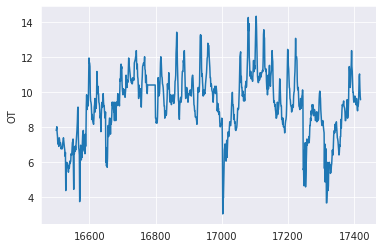

In [ ]:
sns.lineplot(data=etth_data['OT'][16500:])

In [ ]:
def time_features(dates, timeenc, frequency):
   if timeenc == 0:
     dates['month'] = dates.date.apply(lambda row: row.month, 1)
     dates['day'] = dates.date.apply(lambda row: row.day, 1)
     dates['weekday'] = dates.date.apply(lambda row: row.weekday(), 1)
     dates['hour'] = dates.date.apply(lambda row: row.hour, 1)
     dates['minute'] = dates.date.apply(lambda row: row.minute, 1)
     dates['minute'] = dates.minute.map(lambda x: x // 15)
     frequency_map = {'y':[], 'm':['month'], 'w':['month'], 'd':['month','day','weekday'], 
                      'b':['month','day','weekday'], 'h':['month','day','weekday','hour'],
                      't':['month','day','weekday','hour','minute']
                      }
     return dates[frequency_map[frequency.lower()]].values


In [ ]:
def read_data(df_raw, features, flag_id) -> Tuple[np.ndarray, np.ndarray]:

  scaler = StandardScaler()
  
  #Train/Test/Val = 12/4/4 months
  border1s = [0, 12*30*24 - seq_len,  12*30*24+4*30*24 - seq_len]
  border2s = [12*30*24, 12*30*24+4*30*24, 12*30*24+8*30*24]
  
  border1 = border1s[flag_id]
  border2 = border2s[flag_id]

  if features == "M" or features == "MS":
    cols = df_raw.columns[1:]
    df_data = df_raw[cols]
  elif features == "S":
    df_data = df_raw[[target]]
 
  if scale:
    train_data = df_data[border1s[0] : border2s[0]]
    scaler.fit(train_data)
    data = scaler.transform(df_data.values)
  else:
    data = df_data.values
 
  df_stamp = df_raw[['date']][border1:border2]
  df_stamp['date'] = pd.to_datetime(df_stamp.date)

  data_stamp = time_features(df_stamp, timeenc, frequency)
  data_x = data[border1:border2]

  return data_x, data_stamp

In [ ]:
def split_window(window) -> tf.Tensor:
  y_start = seq_len - label_len
  y_end = y_start + label_len + pred_len
  return window[:seq_len], window[y_start:y_end]

In [ ]:
def process_window(window, window_mark) -> Tuple[List[tf.Tensor], tf.Tensor]:
   x_enc = window[0]
   x_dec = tf.identity(window[1])

   x_dec = tf.concat([x_dec[:-pred_len], tf.zeros((pred_len, x_dec.shape[1]), dtype=tf.float64)], 0)

   x_mark_enc = window_mark[0]
   x_mark_dec = window_mark[1]
   
   y = window[1][-pred_len:]
   
   return (x_enc, x_dec, x_mark_enc, x_mark_dec), y

In [ ]:
def create_dataset(data, drop_remainder) -> tf.data.Dataset:
  dataset = tf.data.Dataset.from_tensor_slices(data)

  dataset = dataset.window(seq_len + pred_len, shift=1, drop_remainder=drop_remainder)
  dataset = dataset.flat_map(lambda window: window.batch(seq_len + pred_len))
  
  dataset = dataset.map(split_window, num_parallel_calls=tf.data.AUTOTUNE)
  return dataset

In [ ]:
def CustomDataset(flag='train', batch_size = 32, drop_remainder=True) -> tf.data.Dataset:
  assert flag in ['train', 'test', 'val']
  type_map = {'train': 0, 'val': 1, 'test': 2}
  
  df_raw = pd.read_csv(os.path.join(root_path, data_path))
  
  data_x, data_stamp = read_data(df_raw, features, type_map[flag])

  ds_features = create_dataset(data_x, drop_remainder)
  ds_stamp = create_dataset(data_stamp, drop_remainder)
  
  dataset = tf.data.Dataset.zip((ds_features, ds_stamp))
  dataset = dataset.map(process_window, num_parallel_calls=tf.data.AUTOTUNE)
  dataset = dataset.batch(batch_size, drop_remainder=drop_remainder)
  
  return dataset

# **Training, Validation & Testing**

In [ ]:
import datetime

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint, TensorBoard

%load_ext tensorboard

In [ ]:
BATCH_SIZE = 32
EPOCHS = 8

ds_train = CustomDataset('train', BATCH_SIZE)
ds_val = CustomDataset('val', BATCH_SIZE)
ds_test = CustomDataset('test', BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "
/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "
/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply t

In [ ]:
# for (e, d, mE, mD), y in ds_train.take(1):
#   print(f'Encoder input: {e[0].numpy()}\n\nDecoder Input: {d[0].numpy()}\n\nLabel: {y[0].numpy()}')

In [ ]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
checkpoint_dir = "weights_checkpoint"

early_stopping = EarlyStopping(monitor='loss', patience=7)
lr_scheduler = LearningRateScheduler(lambda epoch: 1e-4 * (0.5 ** ((epoch -1) // 1)))
model_checkpoint = ModelCheckpoint(checkpoint_dir, monitor='loss', save_best_only=True, save_weights_only=True)
tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=1)

etth_model = Informer(enc_layers=3, dec_layers=5, training=True)

etth_model.compile(optimizer= Adam(learning_rate=1e-4), loss='mse', metrics=['mse', 'mae'])

In [ ]:
# tf.keras.backend.clear_session()
# etth_history = etth_model.fit(ds_train, validation_data=ds_val, epochs=50, callbacks=[early_stopping, model_checkpoint, tensorboard])

In [ ]:
# tf.saved_model.save(etth_model, 'etth_saved_model')

# **Hyperparameter Tuning**
Initial loss value matters, the lesser the initial loss value from the first epoch, the faster we can reach a better MSE before starting to overfit.

In [ ]:
pip install -q -U keras-tuner

     |████████████████████████████████| 97 kB 3.1 MB/s 


In [ ]:
import keras_tuner as kt

In [ ]:
def model_builder(hp):
  hp_enc_layers = hp.Int('num_encoder_layers', 1, 3, default=1)
  hp_dec_layers = hp.Int('num_decoder_layers', 2, 5, default=2)
  hp_dropout_rate = hp.Float('dropout_rate', 0, 0.5, step=0.01, default=0.05)
  hp_expansion = hp.Int('expansion', 1, 4, default=4)
  hp_factor = hp.Int('factor', 1, 10, default=5)
  hp_learning_rate = hp.Fixed('learning_rate', 1e-4)

  kt_etth_model = Informer(enc_layers=hp_enc_layers, dec_layers=hp_dec_layers, dropout_rate=hp_dropout_rate, 
                           factor = hp_factor, expansion = hp_expansion, training=True)
  kt_etth_model.compile(optimizer= Adam(learning_rate=hp_learning_rate), loss='mse', metrics=['mse'])

  return kt_etth_model

In [ ]:
kt_early_stopping = EarlyStopping(monitor='loss', patience=4)
kt_lr_scheduler = LearningRateScheduler(lambda epoch: 1e-4 * (0.5 ** ((epoch -1) // 1)))

tuner = kt.Hyperband(model_builder, objective='val_mse', max_epochs=10, factor=3, directory='/content/', project_name='kt_etth_tuning')
tuner.search(ds_train, validation_data=ds_val, epochs=50, callbacks=[kt_early_stopping, kt_lr_scheduler])

Trial 30 Complete [00h 23m 11s]
val_mse: 1.6019867658615112

Best val_mse So Far: 1.6019867658615112
Total elapsed time: 05h 38m 49s
INFO:tensorflow:Oracle triggered exit
